# Cheesing Iron Hunting

I'm building a stupid expensive item sorter, and I've already gone through, like, three stacks of iron blocks. I just want to find one of those iron veins and be done with it, and I can totally live with cheesing it by sifting through block data.

## Imports, Setup and Macros

In [1]:
import json
from collections import Counter
from os import environ
from pathlib import Path
from typing import Any, Collection, Dict, List, Tuple

import mutf8
import pandas as pd
from IPython.display import Markdown, display
from nbt import nbt, region

In [2]:
def format_file_size(path: Path) -> str:
    """Print the size of the specified file in
    human-readible form (KB / MB / GB)

    Parameters
    ----------
    path : Path
        The path to the file

    Returns
    -------
    str
        A prettily formatted file size

    Notes
    -----
    I would be shocked if there isn't a utility already built
    into the standard library to do this, but all I could find
    via Googling was a bunch of recipes and examples
    """
    size = path.stat().st_size  # in bytes
    for unit in ("B", "KB", "MB", "GB"):
        if size < 1024 / 2:
            return f"{size:.1f} {unit}"
        size = size / 1024
    return f"{size} TB"

In [3]:
def summarize_keystore(keystore: Dict[str, Any]) -> None:
    """Display a summary of the contents of a key-value store

    Parameters
    ----------
    keystore : dict
        The keystore to summarize

    Returns
    -------
    None
    """

    def _summarize_keystore(keystore: Dict[str, Any]) -> str:
        summary = ""
        for k, v in keystore.items():
            summary += f"\n - `{k}` : "
            if isinstance(v, (str, nbt.TAG_String)):
                summary += f'`"{v}"`'
            elif not isinstance(v, Collection):
                summary += f"`{str(v)}`"
            else:
                length = len(v)
                if 0 < length < 3:
                    summary += "\n"
                    if not isinstance(v, Dict):
                        v = {i: item for i, item in enumerate(v)}
                    summary += "\n".join(
                        (f"\t{line}" for line in _summarize_keystore(v).split("\n"))
                    )
                else:
                    summary += f"({len(v)} items)"
        return summary

    display(Markdown(_summarize_keystore(keystore)))

In [4]:
save_folder = Path(environ["SAVE_PATH"])

# make sure this is set correctly
for path in sorted(save_folder.glob("*")):
    print(f"- {path.name} ({'folder' if path.is_dir() else format_file_size(path)})")

- DIM-1 (folder)
- DIM1 (folder)
- advancements (folder)
- data (folder)
- datapacks (folder)
- entities (folder)
- icon.png (8.6 KB)
- level.dat (12.0 KB)
- level.dat_old (12.0 KB)
- level11326231134829879582.dat (0.0 B)
- level14927678268100607923.dat (0.0 B)
- level1786655981796876926.dat (0.0 B)
- level4463453738642305340.dat (0.0 B)
- level6425531070021529407.dat (0.0 B)
- level7443636089696258371.dat (0.0 B)
- level8832581565660323154.dat (0.0 B)
- playerdata (folder)
- poi (folder)
- region (folder)
- serverconfig (folder)
- session.lock (3.0 B)
- stats (folder)


## Start with the Region Folder

In [5]:
all_region_files = sorted((save_folder / "region").glob("*"))
for path in all_region_files[:10]:
    print(f"- {path.name} ({'folder' if path.is_dir() else format_file_size(path)})")
print(f"... {len(all_region_files) - 10} more")

- r.-1.-1.mca (9.3 MB)
- r.-1.-10.mca (9.3 MB)
- r.-1.-11.mca (9.2 MB)
- r.-1.-12.mca (10.0 MB)
- r.-1.-13.mca (10.5 MB)
- r.-1.-14.mca (0.5 MB)
- r.-1.-2.mca (9.1 MB)
- r.-1.-3.mca (9.4 MB)
- r.-1.-4.mca (10.2 MB)
- r.-1.-5.mca (10.0 MB)
... 381 more


Let's inspect the first of these files

In [6]:
region_data = region.RegionFile(all_region_files[0])
first_chunk = next(region_data.iter_chunks())
summarize_keystore(first_chunk)


 - `Status` : `"full"`
 - `zPos` : `-32`
 - `block_entities` : (0 items)
 - `yPos` : `-4`
 - `LastUpdate` : `18728329`
 - `structures` : 
	
	 - `0` : `"References"`
	 - `1` : `"starts"`
 - `InhabitedTime` : `692`
 - `xPos` : `-32`
 - `Heightmaps` : (4 items)
 - `sections` : (24 items)
 - `isLightOn` : `1`
 - `block_ticks` : (0 items)
 - `PostProcessing` : (24 items)
 - `DataVersion` : `2865`
 - `fluid_ticks` : (11 items)

Hmm... sections?

In [7]:
summarize_keystore(first_chunk["sections"][0])


 - `block_states` : 
	
	 - `0` : `"data"`
	 - `1` : `"palette"`
 - `biomes` : 
	
	 - `0` : `"palette"`
 - `BlockLight` : (2048 items)
 - `Y` : `-4`

Yep this is it. If I processed what I read correctly, the way this works is that the set of unique blocks in a chunk (section) are encoded as the "palette" and then the "data" just says which block from the palette is in which place.

In [8]:
summarize_keystore(first_chunk["sections"][0]["block_states"]["palette"][0])


 - `Name` : `"minecraft:bedrock"`

So, real quick: that "Y = -4" business--no bedrock is generating at -4. Like with chunk xPos / yPos, we're gonna have to multiply that by 16.

In [9]:
[block["Name"] for block in first_chunk["sections"][0]["block_states"]["palette"]]

[minecraft:bedrock,
 minecraft:deepslate,
 minecraft:tuff,
 minecraft:deepslate_iron_ore,
 minecraft:lava,
 minecraft:deepslate_diamond_ore,
 minecraft:deepslate_redstone_ore,
 minecraft:gravel,
 minecraft:deepslate_gold_ore]

Haha, this randomly selected chunklet has iron ore (_and diamonds!_) and might even be part of a vein. But the dead giveaway isn't the iron ore--it's the iron blocks, so I'd rather keep hunting.

In [10]:
for section in first_chunk["sections"]:
    if "minecraft:raw_iron_block" in [
        str(block["Name"]) for block in section["block_states"]["palette"]
    ]:
        print(f"Found raw iron in section y={section['Y'].value * 16}")
        break

Well can't expect to find one in the very first chunk...

In [11]:
%%time
for chunk in region_data.iter_chunks():
    for section in chunk["sections"]:
        if "minecraft:raw_iron_block" in [
            str(block["Name"]) for block in section["block_states"]["palette"]
        ]:
            print(
                "Found raw iron somewhere around"
                f" ({chunk['xPos'].value * 16},"
                f" {section['Y'].value * 16},"
                f" {chunk['zPos'].value * 16})"
            )
            break
    else:
        continue
    break

Found raw iron somewhere around (-464, -32, -304)
CPU times: user 354 ms, sys: 1.26 ms, total: 355 ms
Wall time: 356 ms


Oh wow that was quick. Let's see how many blocks of raw iron are in this chunklet.

In [12]:
[str(block["Name"]) for block in section["block_states"]["palette"]]

['minecraft:deepslate',
 'minecraft:tuff',
 'minecraft:deepslate_iron_ore',
 'minecraft:air',
 'minecraft:raw_iron_block',
 'minecraft:deepslate_gold_ore',
 'minecraft:gravel',
 'minecraft:deepslate_lapis_ore']

In [13]:
len([v for v in section["block_states"]["data"]])

256

In [14]:
[v for v in section["block_states"]["data"]][:10]

[1103806595072, 4580179968, 4563468288, 0, 0, 0, 0, 0, 0, 0]

Okay, I expected these to be, like, the indices in the palette, but it turns out they're
> 4096 indices pointing to the palette, stored in an array of 64-bit integers

Okay, so first hint is that since this array is only 256 long, each must contain the data for 16 blocks.

In [15]:
def split_block_value(value: int) -> List[int]:
    """Split a 64-bit int into 16x 4-bit ints

    Parameters
    ----------
    value: 64-bit int
        The int to split

    Returns
    -------
    list of 16x 4-bit ints
    """
    small_ints = []
    for _ in range(16):
        value, remainder = divmod(value, 2**4)
        small_ints.insert(0, remainder)
    return small_ints

Okay, so if I did this correctly, every single value in this section should be 0-7 (since the palette was 8-long).

In [16]:
split_blocks = sum([split_block_value(v) for v in section["block_states"]["data"]], [])

In [17]:
len(split_blocks)

4096

In [18]:
Counter(split_blocks)

Counter({0: 3525, 1: 193, 2: 10, 3: 204, 4: 1, 5: 12, 6: 147, 7: 4})

Nice!

And--kinda as expected--there's just one raw iron block in this section.

## Now can I find anything closer?

I mean, this being near (0,0) is pretty cool and all, but I'm way out... um... where am I again?

In [19]:
my_coords = tuple(
    float(str(coord))
    for coord in nbt.NBTFile(save_folder / "level.dat")["Data"]["Player"]["Pos"]
)
my_coords

(-1169.524564075365, -58.0, -4292.300000011921)

Okay, so that would put me in region...

In [20]:
region_filename = f"r.{int(my_coords[0] // 512 )}.{int(my_coords[2] // 512)}.mca"
region_filename

'r.-3.-9.mca'

In [21]:
%%time
region_data = region.RegionFile(save_folder / "region" / region_filename)
vein_chunklets = []  # type: List[Tuple[Tuple[int, int, int], nbt.TAG_Compound]]
for chunk in region_data.iter_chunks():
    for section in chunk["sections"]:
        if "minecraft:raw_iron_block" in [
            str(block["Name"]) for block in section["block_states"]["palette"]
        ]:
            coords = (
                chunk["xPos"].value * 16,
                section["Y"].value * 16,
                chunk["zPos"].value * 16,
            )
            if len(vein_chunklets) < 10:
                print(f"Found raw iron somewhere around {coords}")
            vein_chunklets.append((coords, section))
if len(vein_chunklets) > 10:
    print(f"... plus {len(vein_chunklets) - 10} more")

Found raw iron somewhere around (-1328, -64, -4400)
Found raw iron somewhere around (-1328, -32, -4400)
Found raw iron somewhere around (-1328, -32, -4368)
Found raw iron somewhere around (-1328, -64, -4352)
Found raw iron somewhere around (-1328, -32, -4352)
Found raw iron somewhere around (-1312, -16, -4464)
Found raw iron somewhere around (-1312, -32, -4432)
Found raw iron somewhere around (-1312, -32, -4416)
Found raw iron somewhere around (-1312, -64, -4400)
Found raw iron somewhere around (-1312, -48, -4400)
... plus 49 more
CPU times: user 2.61 s, sys: 5.93 ms, total: 2.62 s
Wall time: 2.62 s


In [22]:
vein_chunklets = sorted(
    vein_chunklets, key=lambda x: sum([(my_coords[i] - x[0][i]) ** 2 for i in range(3)])
)
print(f"Closest vein chunklet at {vein_chunklets[0][0]}")

Closest vein chunklet at (-1248, -64, -4336)


## Could I narrow that down a bit?

So I've found part of an iron ore vein somewhere in the 16x16x16 cube starting at (-1248, -64, -4336), but that's a pretty big cube.

Luckily, veins are supposed to be pretty darn big.

It would be one thing if I were looking for diamonds or ancient debris (soon...) but I'm just trying to find an area that's generally worth searching.

So I'm not going to bother trying to track that down any more than just noting the composition of that chunklet. And actually, let's look at a few different chunklets for comparison:

In [23]:
for coords, section in vein_chunklets[:3]:
    display(Markdown(f"#### {coords}"))
    palette = [str(block["Name"]) for block in section["block_states"]["palette"]]
    split_blocks = sum(
        [split_block_value(v) for v in section["block_states"]["data"]], []
    )
    display(Markdown("Composition:"))
    display({palette[k]: v for k, v in Counter(split_blocks).items()})

#### (-1248, -64, -4336)

Composition:

{'minecraft:bedrock': 765,
 'minecraft:deepslate': 2221,
 'minecraft:deepslate_diamond_ore': 4,
 'minecraft:deepslate_redstone_ore': 30,
 'minecraft:lava': 311,
 'minecraft:tuff': 740,
 'minecraft:deepslate_iron_ore': 15,
 'minecraft:deepslate_lapis_ore': 9,
 'minecraft:raw_iron_block': 1}

#### (-1264, -32, -4320)

Composition:

{'minecraft:deepslate': 2690,
 'minecraft:gravel': 44,
 'minecraft:air': 773,
 'minecraft:tuff': 520,
 'minecraft:deepslate_redstone_ore': 12,
 'minecraft:deepslate_iron_ore': 31,
 'minecraft:deepslate_lapis_ore': 4,
 'minecraft:raw_iron_block': 1,
 'minecraft:deepslate_gold_ore': 7,
 'minecraft:water': 6,
 'minecraft:glow_lichen': 1}

#### (-1248, -32, -4352)

Composition:

{'minecraft:deepslate': 3192,
 'minecraft:deepslate_iron_ore': 18,
 'minecraft:tuff': 140,
 'minecraft:air': 737,
 'minecraft:gravel': 7,
 'minecraft:raw_iron_block': 1,
 'minecraft:water': 1}

Those diamonds in the first chunk are hella tempting, but that second chunk is exposed to air (and also doesn't have any lava). So that's where I think I'm headed.

## So How'd it Go?

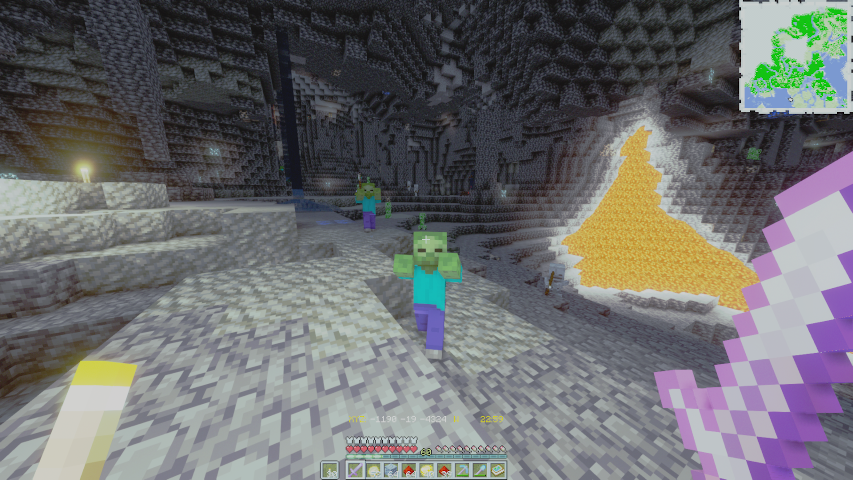